#NASA CMAPSS - Predictive Maintenance using LSTM
This notebook builds an LSTM-based model to predict Remaining Useful Life (RUL) for aircraft engines using the FD001 subset of the CMAPSS dataset.

✅ Includes:

* Data loading
* RUL computation
* Data preprocessing and normalization
* Baseline Models
* Sequence creation for LSTM
* LSTM model training and evaluation
* Test set prediction
* Feature Engineering (FFT)
* Data Preparation for CNN-LSTM
* Model Building (CNN-LSTM Hybrid)
* Model Training (CNN-LSTM Hybrid)
* Data Preparation for Early-Life Training
* Model Training (Early-Life Cycles)
* Data Preparation for Midpoint-Cycle Training
* Model Training (Midpoint-Cycles)
* Evaluation and Warning Time Analysis
* Conclusion

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore

In [15]:
train_df = pd.read_csv(r'C:\Users\user\Hamoye-Capstone_LSTM\CMAPSSData\train_FD001.txt')
train_df.head()

1 1 -0.0007 -0.0004 100.0 518.67 641.82 1589.70 1400.60 14.62 21.61 554.36 2388.06 9046.19 1.30 47.47 521.66 2388.02 8138.62 8.4195 0.03 392 2388 100.00 39.06 23.4190  
0  1 2 0.0019 -0.0003 100.0 518.67 642.15 1591.82...                                                                                                                      
1  1 3 -0.0043 0.0003 100.0 518.67 642.35 1587.99...                                                                                                                      
2  1 4 0.0007 0.0000 100.0 518.67 642.35 1582.79 ...                                                                                                                      
3  1 5 -0.0019 -0.0002 100.0 518.67 642.37 1582.8...                                                                                                                      
4  1 6 -0.0043 -0.0001 100.0 518.67 642.10 1584.4...

In [16]:
# The FD001 dataset has 26 columns:
# 1: engine_id
# 2: cycle
# 3: setting1 (operational setting 1)
# 4: setting2 (operational setting 2)
# 5: setting3 (operational setting 3)
# 6-26: sensor_1 to sensor_21

column_names = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3',
                'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
                'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10',
                'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
                'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
                'sensor21']

# Load the training data
train_df = pd.read_csv(r'C:\Users\user\Hamoye-Capstone_LSTM\CMAPSSData\train_FD001.txt', sep='\s+', header=None, names=column_names)

# Load the test data (without RUL)
test_df = pd.read_csv(r'C:\Users\user\Hamoye-Capstone_LSTM\CMAPSSData\test_FD001.txt', sep='\s+', header=None, names=column_names)

# Load the RUL data for the test set
rul_df = pd.read_csv(r'C:\Users\user\Hamoye-Capstone_LSTM\CMAPSSData\RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("RUL data shape:", rul_df.shape)

Training data shape: (20631, 26)
Test data shape: (13096, 26)
RUL data shape: (100, 1)


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   engine_id  20631 non-null  int64  
 1   cycle      20631 non-null  int64  
 2   setting1   20631 non-null  float64
 3   setting2   20631 non-null  float64
 4   setting3   20631 non-null  float64
 5   sensor1    20631 non-null  float64
 6   sensor2    20631 non-null  float64
 7   sensor3    20631 non-null  float64
 8   sensor4    20631 non-null  float64
 9   sensor5    20631 non-null  float64
 10  sensor6    20631 non-null  float64
 11  sensor7    20631 non-null  float64
 12  sensor8    20631 non-null  float64
 13  sensor9    20631 non-null  float64
 14  sensor10   20631 non-null  float64
 15  sensor11   20631 non-null  float64
 16  sensor12   20631 non-null  float64
 17  sensor13   20631 non-null  float64
 18  sensor14   20631 non-null  float64
 19  sensor15   20631 non-null  float64
 20  sensor

In [18]:
train_df.describe().transpose().head()

count        mean        std       min       25%    50%  \
engine_id  20631.0   51.506568  29.227633    1.0000   26.0000   52.0   
cycle      20631.0  108.807862  68.880990    1.0000   52.0000  104.0   
setting1   20631.0   -0.000009   0.002187   -0.0087   -0.0015    0.0   
setting2   20631.0    0.000002   0.000293   -0.0006   -0.0002    0.0   
setting3   20631.0  100.000000   0.000000  100.0000  100.0000  100.0   

                75%       max  
engine_id   77.0000  100.0000  
cycle      156.0000  362.0000  
setting1     0.0015    0.0087  
setting2     0.0003    0.0006  
setting3   100.0000  100.0000

In [19]:
train_df.isna().sum()

engine_id    0
cycle        0
setting1     0
setting2     0
setting3     0
sensor1      0
sensor2      0
sensor3      0
sensor4      0
sensor5      0
sensor6      0
sensor7      0
sensor8      0
sensor9      0
sensor10     0
sensor11     0
sensor12     0
sensor13     0
sensor14     0
sensor15     0
sensor16     0
sensor17     0
sensor18     0
sensor19     0
sensor20     0
sensor21     0
dtype: int64

In [20]:
train_df.duplicated().sum()

np.int64(0)

In [21]:
# Calculate RUL for training data
rul_max = train_df.groupby('engine_id')['cycle'].max().reset_index()
rul_max.columns = ['engine_id', 'max_cycle']
train_df = train_df.merge(rul_max, on='engine_id')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

# Show RUL
print(train_df[['engine_id', 'cycle', 'RUL']].head(10))

   engine_id  cycle  RUL
0          1      1  191
1          1      2  190
2          1      3  189
3          1      4  188
4          1      5  187
5          1      6  186
6          1      7  185
7          1      8  184
8          1      9  183
9          1     10  182


In [22]:
# Count the number of unique values in the 'engine_id' column of the training dataframe
num_distinct_engines = train_df['engine_id'].nunique()

print(f"Number of distinct engines in the training data: {num_distinct_engines}")

Number of distinct engines in the training data: 100


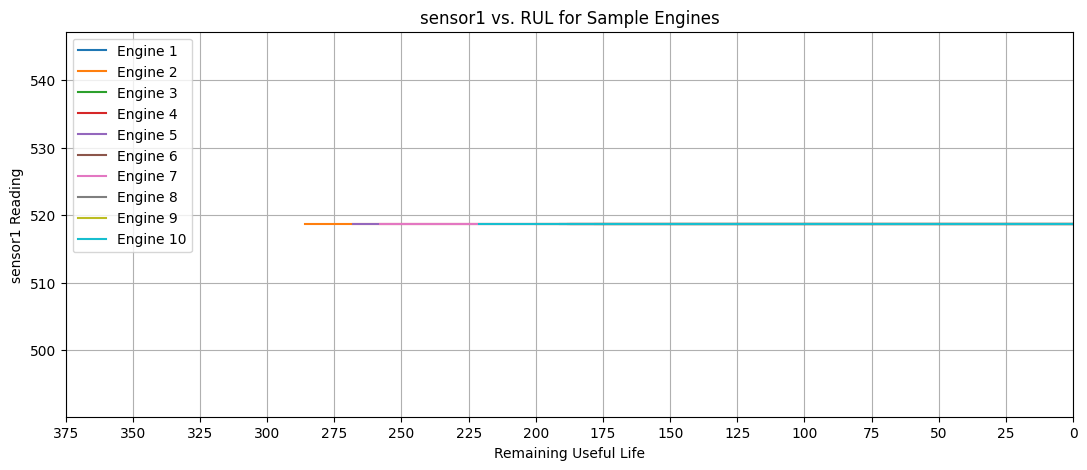

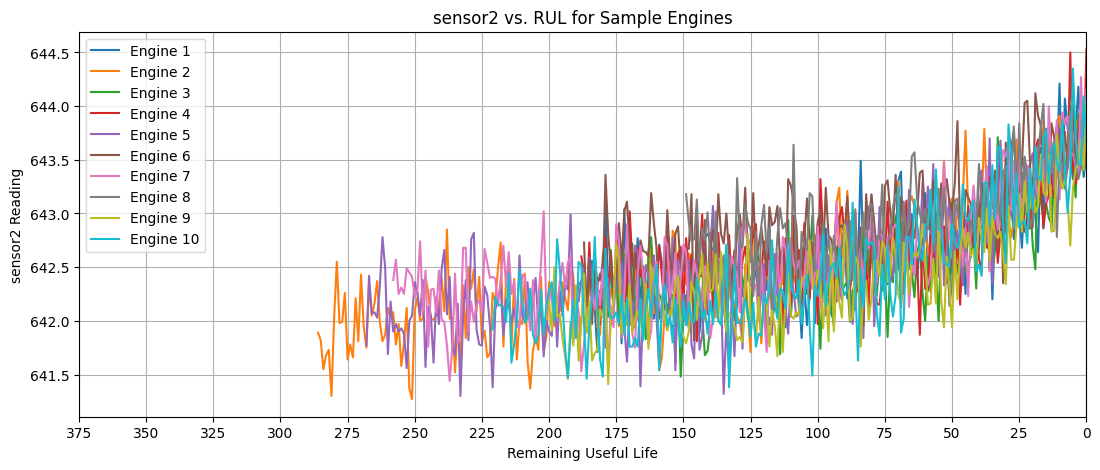

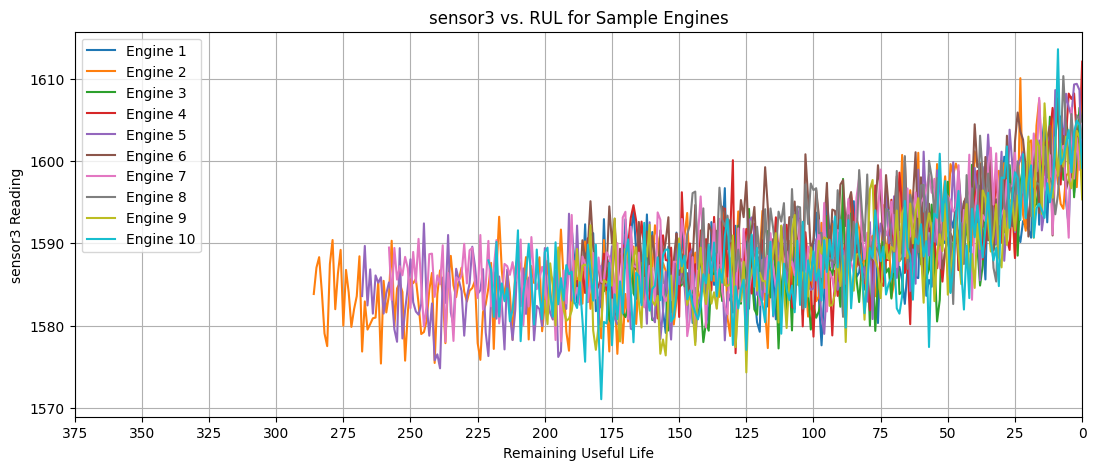

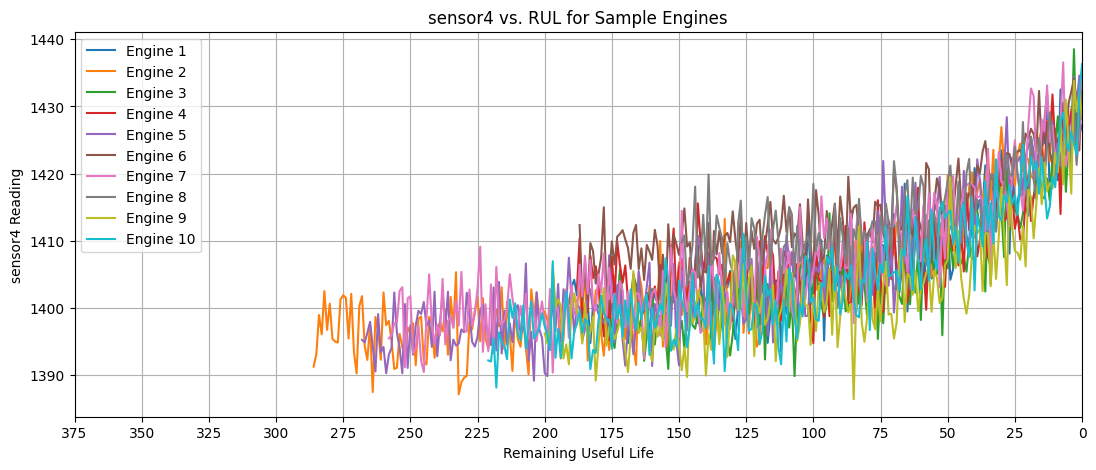

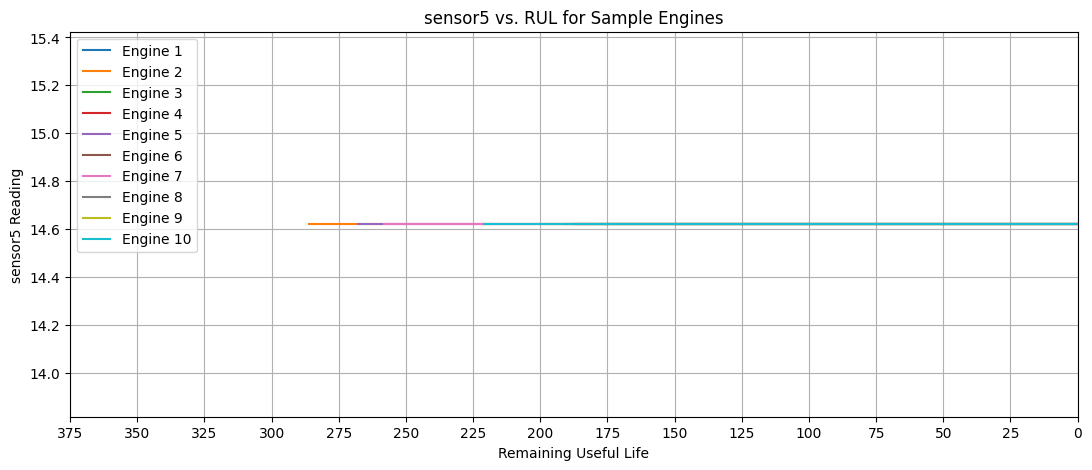

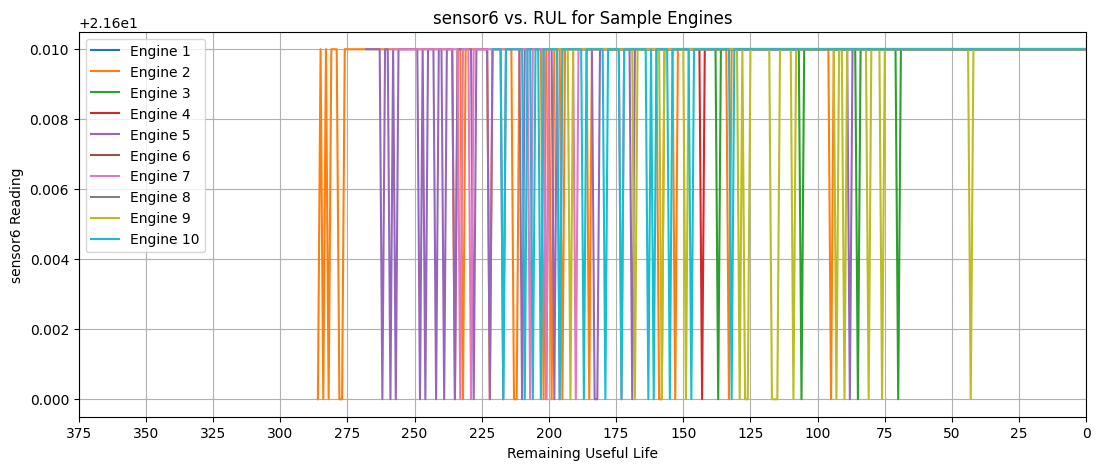

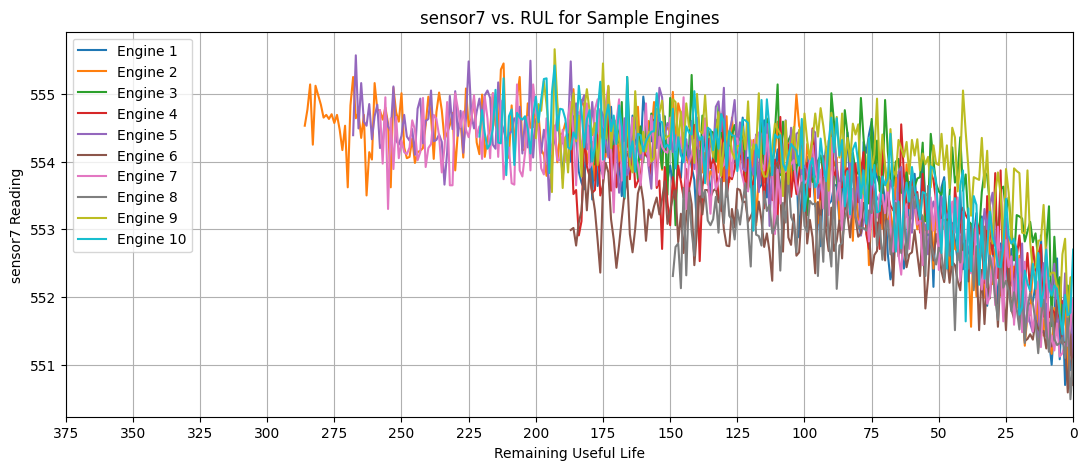

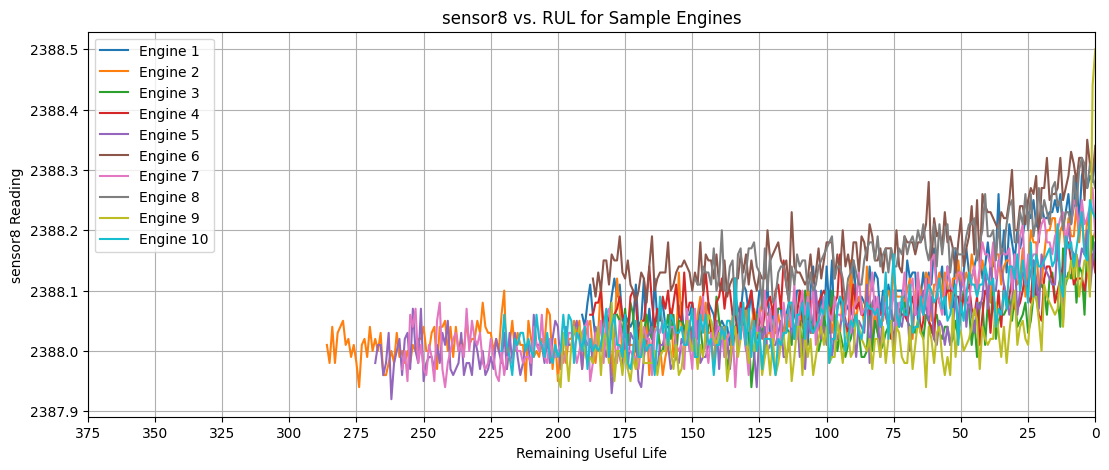

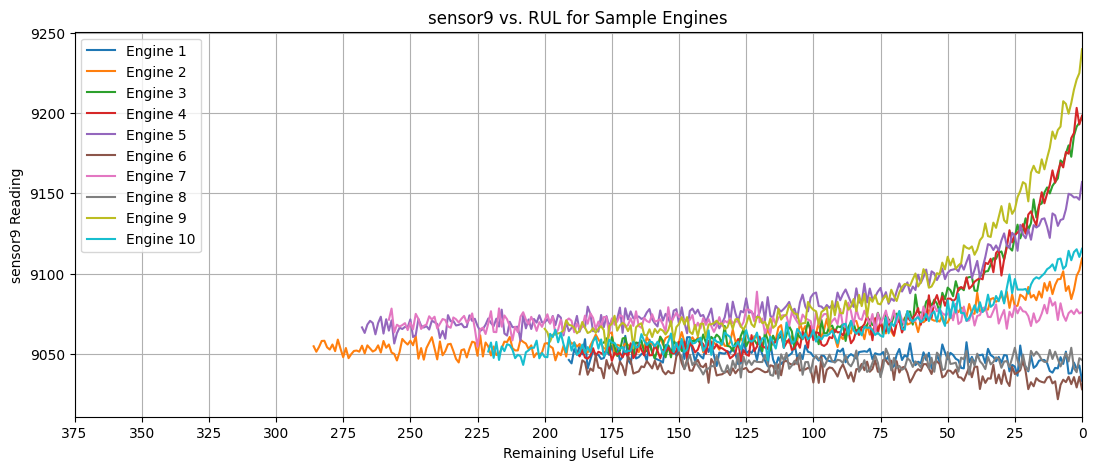

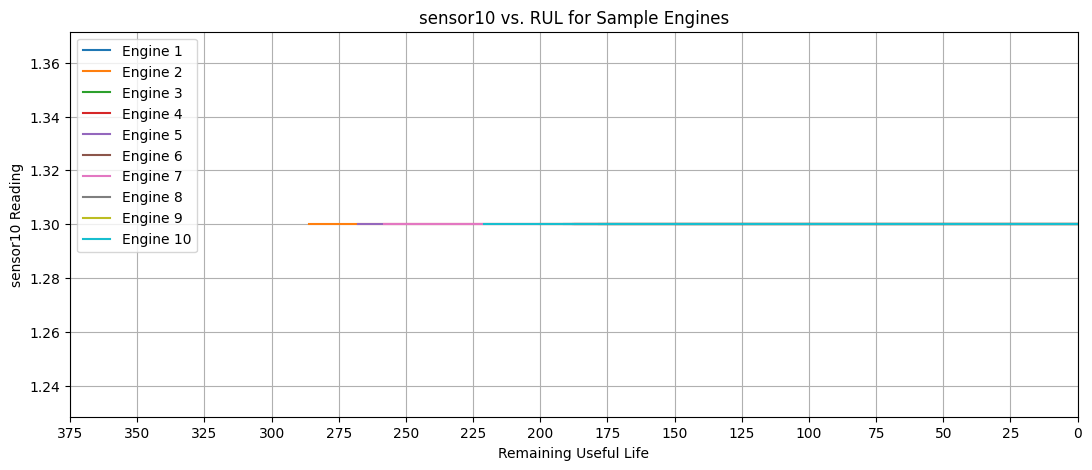

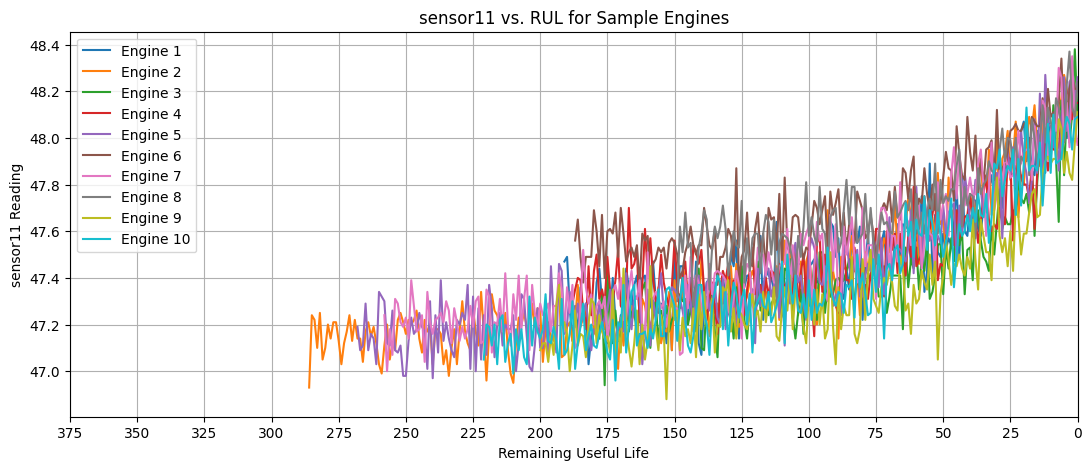

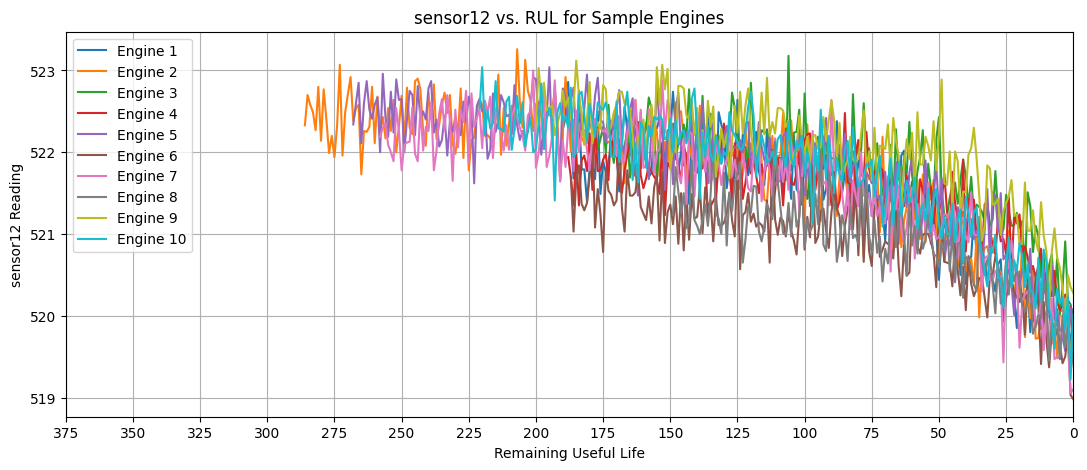

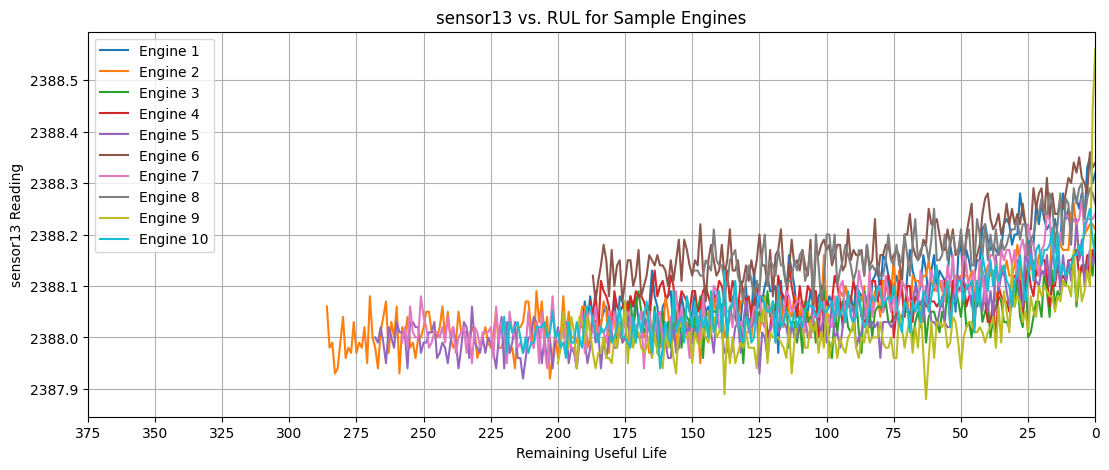

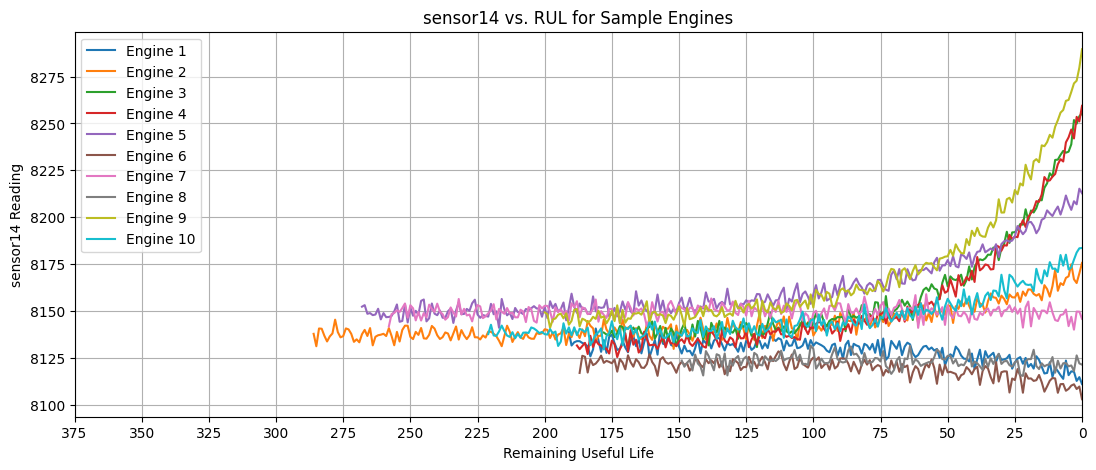

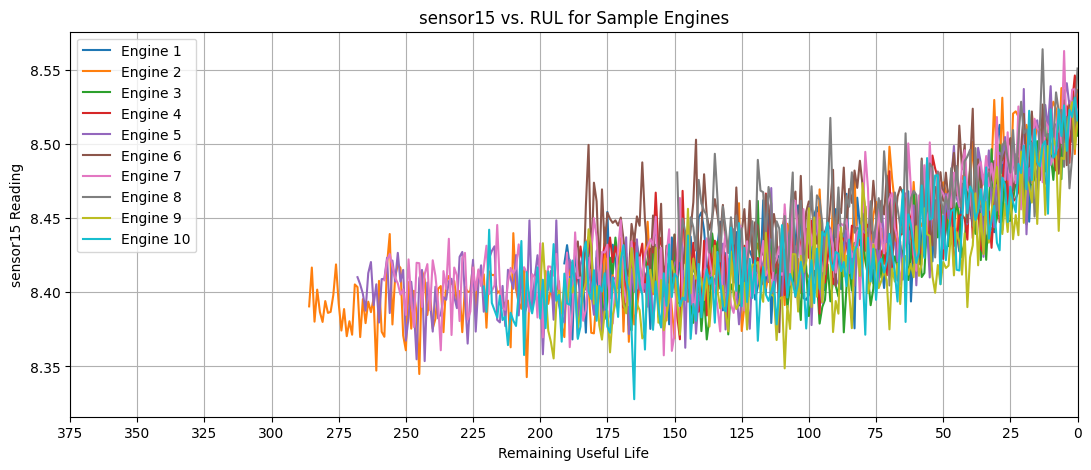

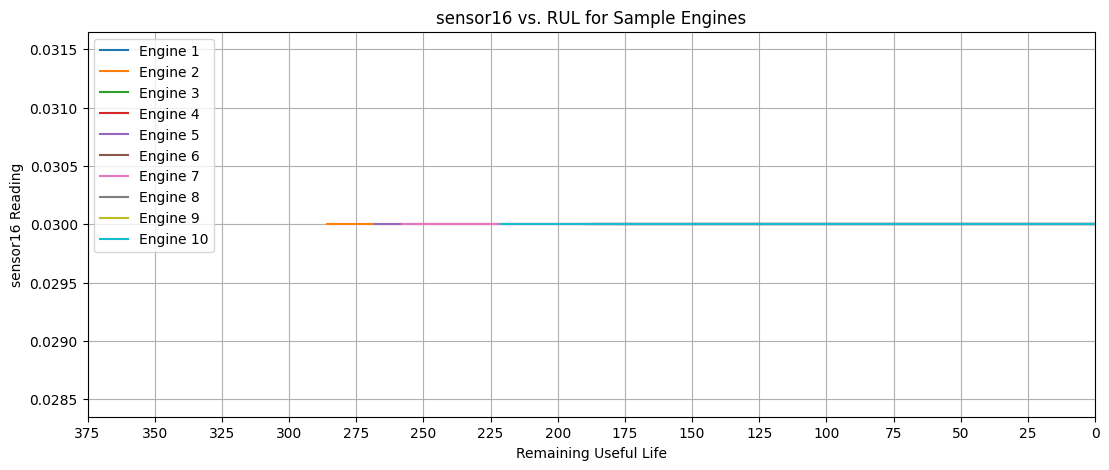

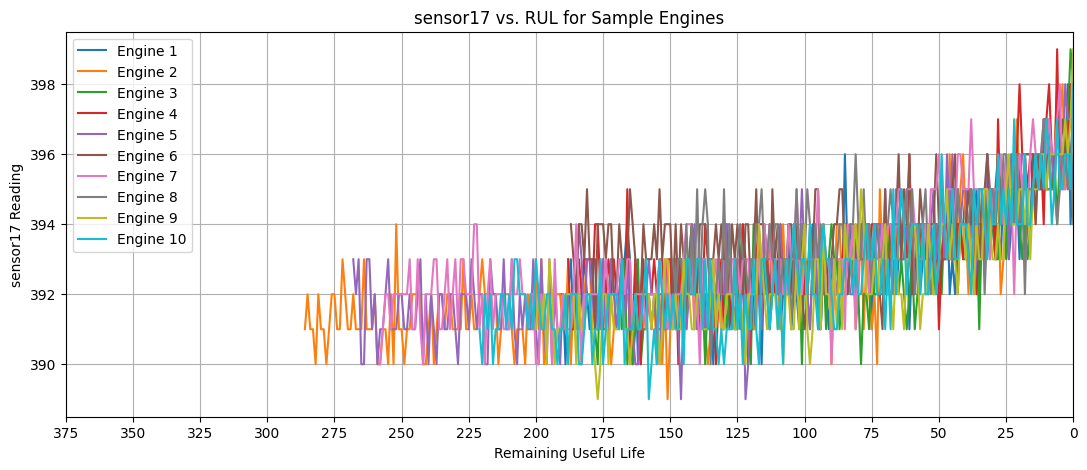

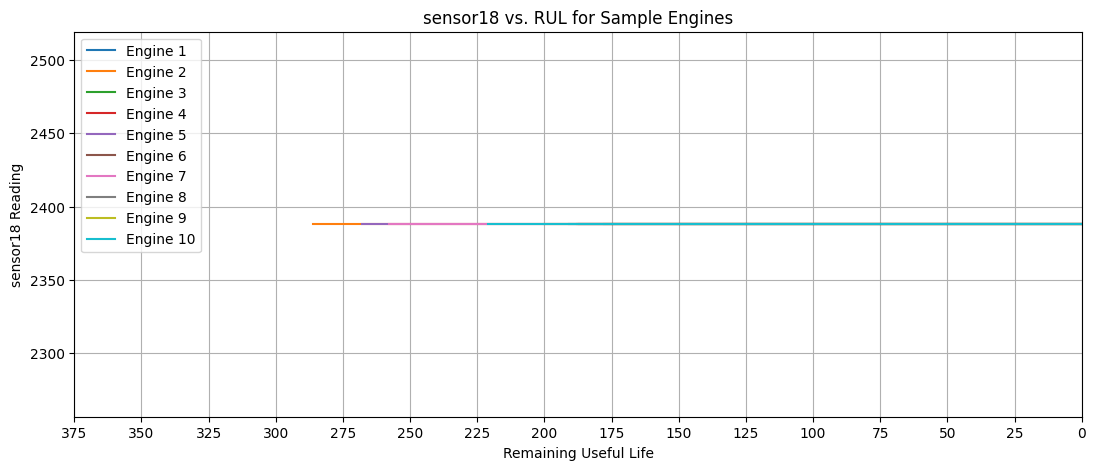

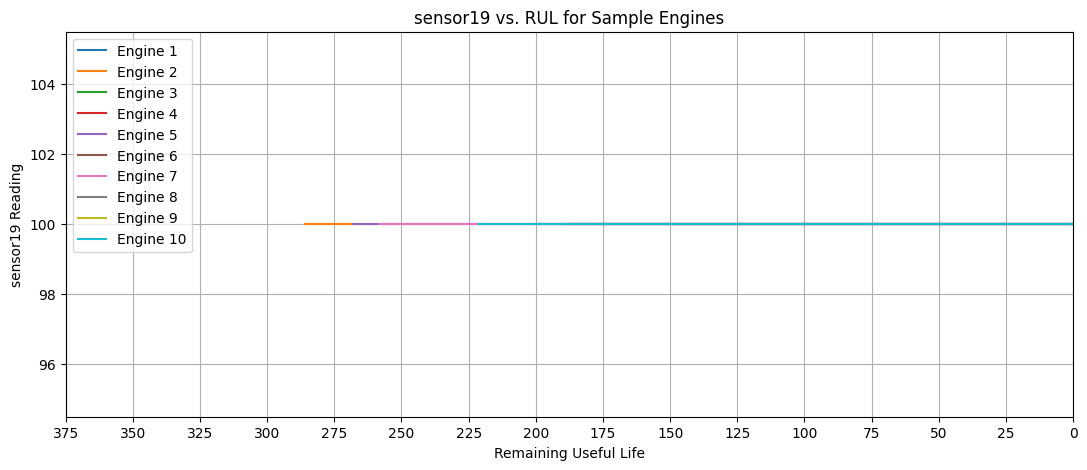

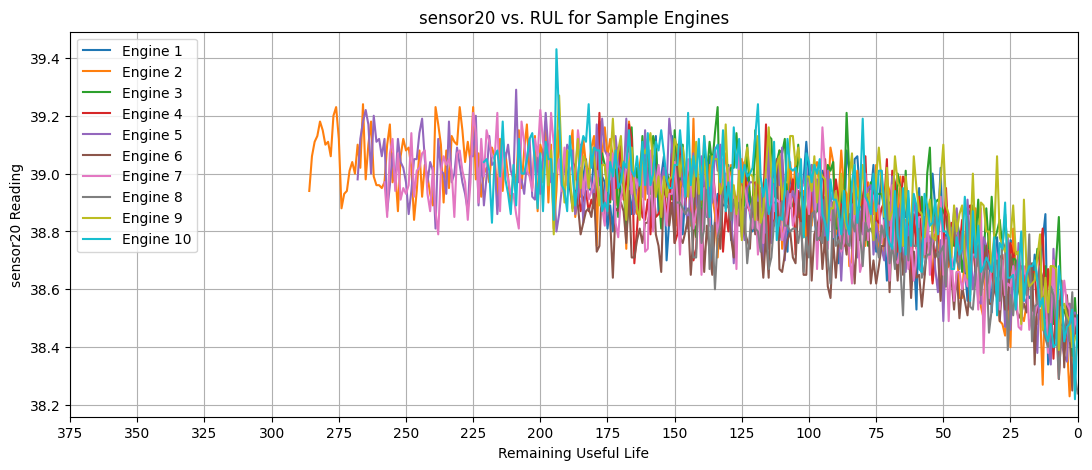

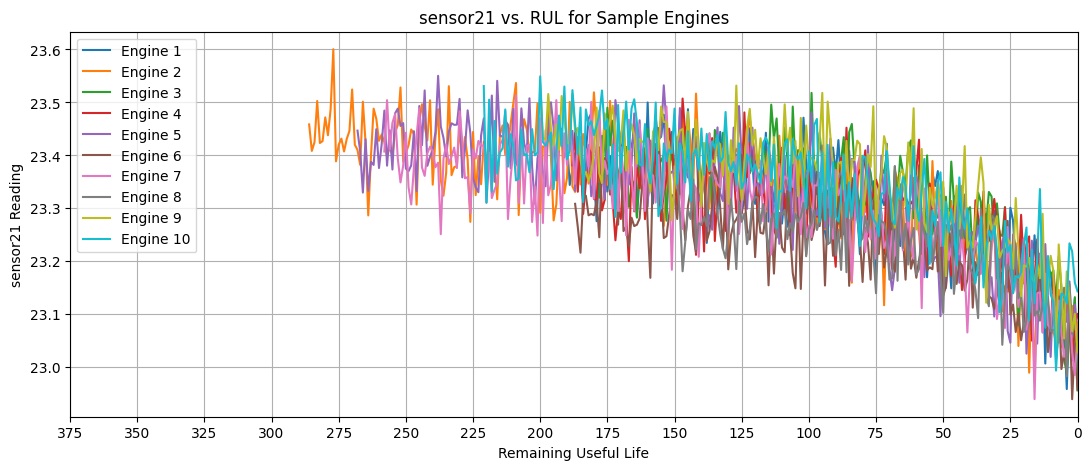

In [23]:
# Get the list of all sensor column names
sensor_cols = [col for col in train_df.columns if 'sensor' in col]

# Select a few engine IDs to visualize on each sensor plot
sample_engine_ids = train_df['engine_id'].unique()[:10]
# Plot the first 10 engines

# Iterate through each sensor column and generate a plot for each sensor
for sensor in sensor_cols:
    plt.figure(figsize=(13, 5))

    plot_count = 0 # Counter for how many engines we've plotted on this figure
    max_plots = 10 # Maximum number of engine trends to show per sensor plot (matches slice above)

    # Iterate through the selected sample engine IDs
    for engine_id in sample_engine_ids:
        if plot_count < max_plots:
            # Filter data for the current engine ID
            engine_data = train_df[train_df['engine_id'] == engine_id]

            # Check if the sensor column exists in the dataframe
            if sensor in engine_data.columns:
                # Plot the sensor reading vs. RUL for this engine
                plt.plot('RUL', sensor, data=engine_data, label=f'Engine {engine_id}')
                plot_count += 1 # Increment counter if we plotted an engine trend
            else:
                 print(f"Warning: Column '{sensor}' not found in dataframe for engine {engine_id}.")
                 # If a sensor is missing for an engine, we might want to skip this engine
                 # for this sensor or handle it differently. For simplicity, we continue.


    # Customizing the plot for the current sensor
    plt.xlim(train_df['RUL'].max(), 0)
    max_rul = train_df['RUL'].max()
    plt.xticks(np.arange(0, max_rul + 25, 25))
    plt.ylabel(f'{sensor} Reading')
    plt.xlabel('Remaining Useful Life')
    plt.title(f'{sensor} vs. RUL for Sample Engines')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [24]:
# Drop uninformative columns
drop_cols = ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor5', 'sensor6', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

# Normalize features
feature_cols = train_df.columns.difference(['engine_id', 'cycle', 'RUL'])
scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

#Baseline models: LR and RF

In [25]:
# Prepare data for Linear Regression
X_train_lr = train_df[feature_cols]
y_train_lr = train_df['RUL']

# Initialize and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

# Prepare test data for Linear Regression prediction
# For baseline models, we can predict RUL for each time step of the test data.
# Later, we will evaluate on the RUL of the *last* cycle of each engine.
X_test_lr = test_df[feature_cols]

# Predict RUL using the trained Linear Regression model
y_pred_lr_all = lr_model.predict(X_test_lr)

# Add predictions back to the test dataframe for easier analysis
test_df['predicted_RUL_LR'] = y_pred_lr_all

# To evaluate, we need the prediction for the last cycle of each test engine.
# The RUL for the test set (rul_df) corresponds to these last cycles.
# We need to get the predicted RUL from test_df for the row where 'cycle' is max for each 'engine_id'.

# Get the last cycle for each engine in the test set
last_cycles = test_df.groupby('engine_id')['cycle'].max().reset_index()
last_cycles.columns = ['engine_id', 'last_cycle']

# Merge to get the predicted RUL at the last cycle
test_results_lr = pd.merge(last_cycles, test_df, left_on=['engine_id', 'last_cycle'], right_on=['engine_id', 'cycle'], how='left')

# The predicted RUL for evaluation is in the 'predicted_RUL_LR' column of test_results_lr
y_pred_lr_final = test_results_lr['predicted_RUL_LR']

# The true RUL for the test set is in rul_df
y_true_test = rul_df['RUL']

# Evaluate Linear Regression
mse_lr = mean_squared_error(y_true_test, y_pred_lr_final)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_true_test, y_pred_lr_final)

print(f'Linear Regression Mean Squared Error: {mse_lr:.4f}')
print(f'Linear Regression Root Mean Squared Error: {rmse_lr:.4f}')
print(f'Linear Regression R2 Score: {r2_lr:.4f}')

Linear Regression Mean Squared Error: 1020.9708
Linear Regression Root Mean Squared Error: 31.9526
Linear Regression R2 Score: 0.4088


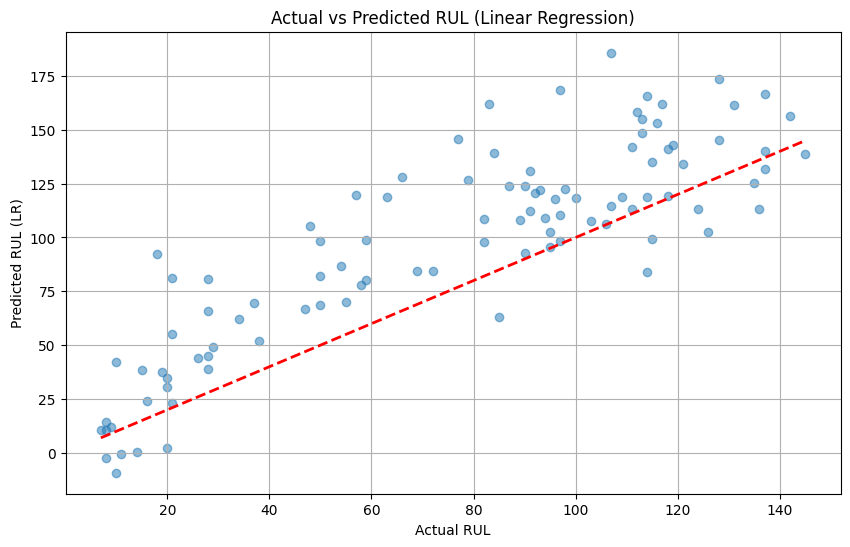

In [26]:
# Visualize Actual vs Predicted RUL for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_true_test, y_pred_lr_final, alpha=0.5)
plt.plot([y_true_test.min(), y_true_test.max()], [y_true_test.min(), y_true_test.max()], 'r--', lw=2) # Ideal line
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL (LR)')
plt.title('Actual vs Predicted RUL (Linear Regression)')
plt.grid(True)
plt.show()

In [27]:
# Prepare data for Random Forest
X_train_rf = train_df[feature_cols]
y_train_rf = train_df['RUL']

# Initialize and train Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf, y_train_rf)

# Prepare test data for Random Forest prediction
X_test_rf = test_df[feature_cols]

# Predict RUL using the trained Random Forest model
y_pred_rf_all = rf_model.predict(X_test_rf)

# Add predictions back to the test dataframe
test_df['predicted_RUL_RF'] = y_pred_rf_all

# Get the predicted RUL for the last cycle of each test engine
# (This reuses the last_cycles dataframe created for LR evaluation)
test_results_rf = pd.merge(last_cycles, test_df, left_on=['engine_id', 'last_cycle'], right_on=['engine_id', 'cycle'], how='left')

# The predicted RUL for evaluation is in the 'predicted_RUL_RF' column of test_results_rf
y_pred_rf_final = test_results_rf['predicted_RUL_RF']

# The true RUL for the test set is already in y_true_test (from LR evaluation)

# Evaluate Random Forest
mse_rf = mean_squared_error(y_true_test, y_pred_rf_final)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_true_test, y_pred_rf_final)

print(f'Random Forest Mean Squared Error: {mse_rf:.4f}')
print(f'Random Forest Root Mean Squared Error: {rmse_rf:.4f}')
print(f'Random Forest R2 Score: {r2_rf:.4f}')

Random Forest Mean Squared Error: 1168.0372
Random Forest Root Mean Squared Error: 34.1766
Random Forest R2 Score: 0.3236


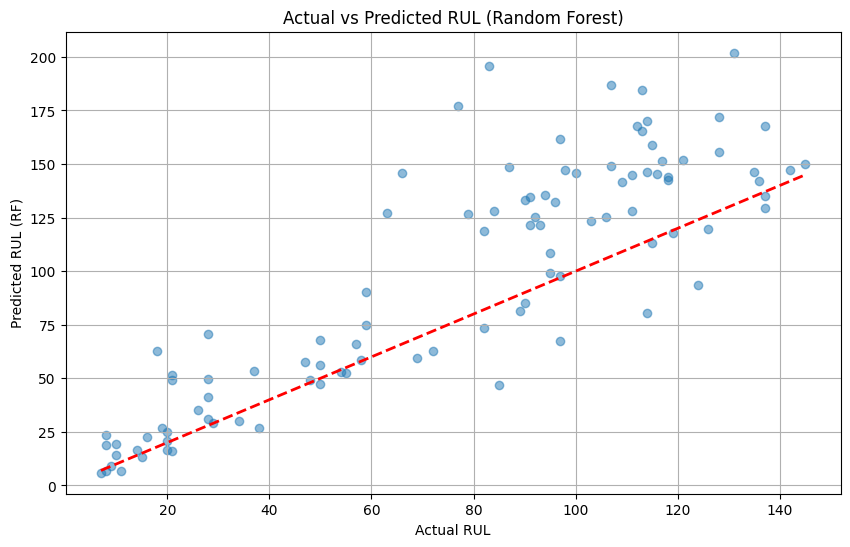

In [28]:
# Visualize Actual vs Predicted RUL for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_true_test, y_pred_rf_final, alpha=0.5)
plt.plot([y_true_test.min(), y_true_test.max()], [y_true_test.min(), y_true_test.max()], 'r--', lw=2) # Ideal line
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL (RF)')
plt.title('Actual vs Predicted RUL (Random Forest)')
plt.grid(True)
plt.show()

#LSTM

In [29]:
def create_sequences(df, seq_len=30):
    X, y = [], []
    for engine in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine]
        for i in range(len(engine_df) - seq_len):
            seq = engine_df.iloc[i:i+seq_len]
            X.append(seq[feature_cols].values)
            y.append(seq.iloc[-1]['RUL'])
    return np.array(X), np.array(y)

X, y = create_sequences(train_df, seq_len=30)
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (17631, 30, 14), y shape: (17631,)


In [30]:
# Split data
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,251 (297.86 KB)

 Trainable params: 76,251 (297.86 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 30s 87ms/step - loss: 10305.8369 - val_loss: 12771.4531
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 8210.8223 - val_loss: 11112.6943
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - loss: 6996.7847 - val_loss: 9771.2227
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - loss: 5947.5176 - val_loss: 8701.0742
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - loss: 5156.3560 - val_loss: 7850.5996
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 4664.4678 - val_loss: 7189.7642
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - loss: 4186.4321 - val_loss: 6683.6021
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - loss: 4037.3113 - val_loss: 6304.7285
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 3766.1924 - val_loss: 6023.2026
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 3589.0688 - val_loss: 5820.3506
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step -

In [36]:
model.save("lstm_rul_model.h5")

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1742.9893
Validation MSE: 1693.9904
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


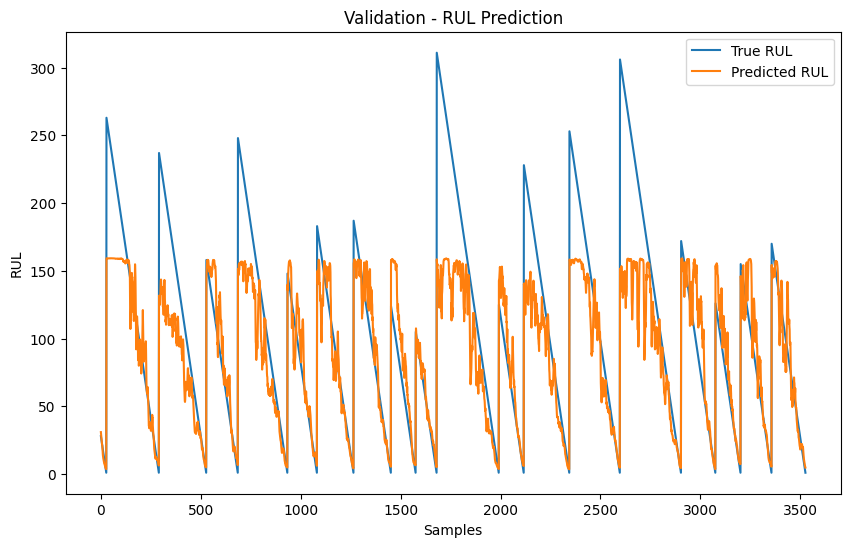

In [32]:
# Evaluate
val_loss = model.evaluate(X_val, y_val)
print(f"Validation MSE: {val_loss:.4f}")

# Plot predictions
y_pred = model.predict(X_val)
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title("Validation - RUL Prediction")
plt.xlabel("Samples")
plt.ylabel("RUL")
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


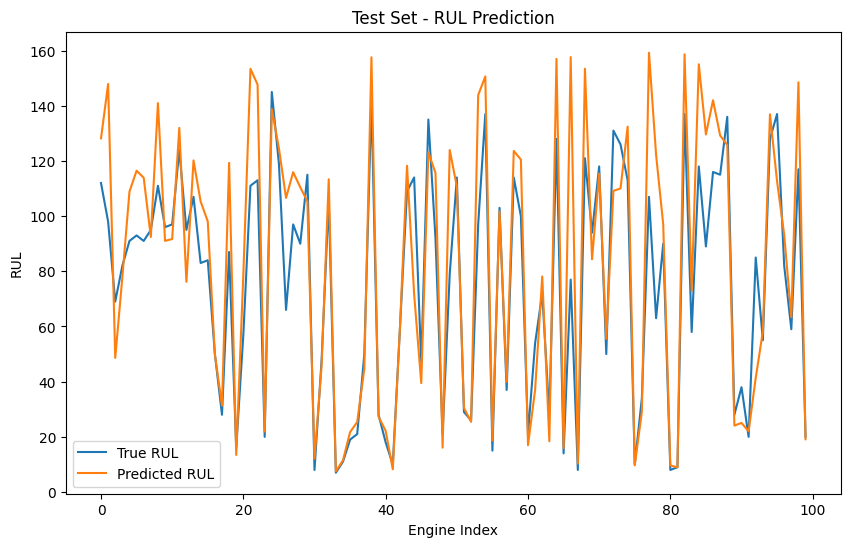

Test RMSE: 21.66


In [33]:
# Prepare sequences from test data
def get_last_sequences(df, seq_len=30):
    X = []
    for engine_id in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine_id].sort_values('cycle')
        if len(engine_df) >= seq_len:
            seq = engine_df.iloc[-seq_len:][feature_cols].values
            X.append(seq)
    return np.array(X)

X_test = get_last_sequences(test_df)
y_test_pred = model.predict(X_test)

# Compare with true RUL
true_rul = rul_df.values[:len(y_test_pred)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='True RUL')
plt.plot(y_test_pred, label='Predicted RUL')
plt.title("Test Set - RUL Prediction")
plt.xlabel("Engine Index")
plt.ylabel("RUL")
plt.legend()
plt.show()

# RMSE
rmse = np.sqrt(mean_squared_error(true_rul, y_test_pred))
print(f"Test RMSE: {rmse:.2f}")


Performance Comparison:
               Model       RMSE        R2
0  Linear Regression  31.952633  0.408774
1      Random Forest  34.176560  0.323610
2               LSTM  21.664143  0.728216


C:\Users\user\AppData\Local\Temp\ipykernel_19352\161662855.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')
C:\Users\user\AppData\Local\Temp\ipykernel_19352\161662855.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=results_df, palette='viridis')


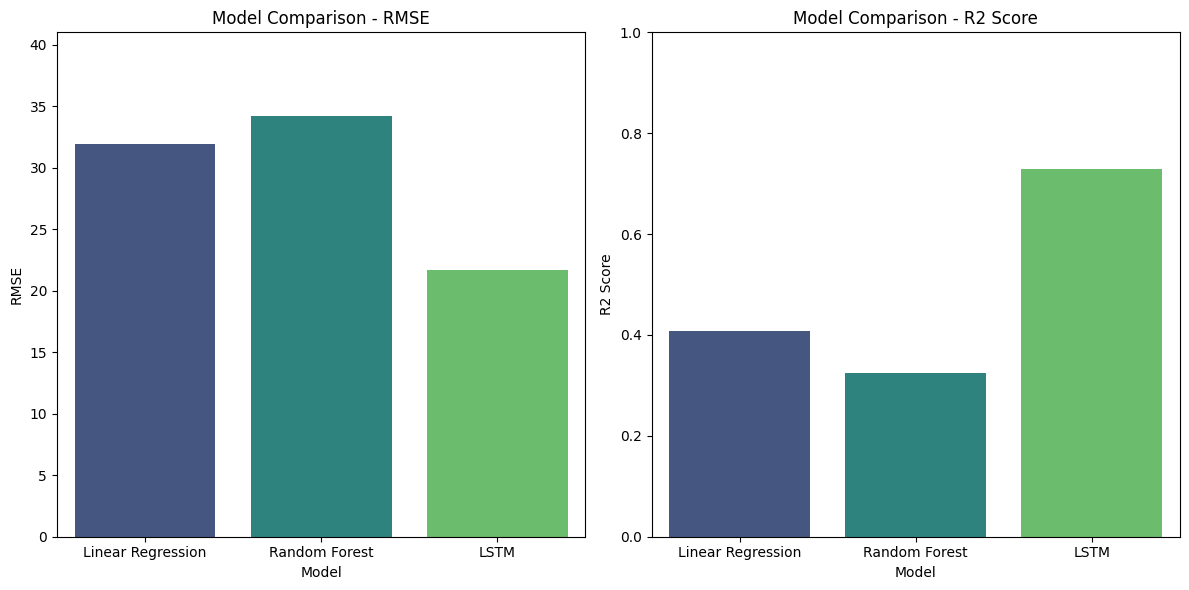

In [34]:
# Store evaluation results
results = {
    'Model': ['Linear Regression', 'Random Forest', 'LSTM'],
    'RMSE': [rmse_lr, rmse_rf, rmse],
    'R2': [r2_lr, r2_rf, r2_score(true_rul, y_test_pred)] # Calculate R2 for LSTM test predictions
}

results_df = pd.DataFrame(results)

print("\nPerformance Comparison:")
print(results_df)

# Visualize performance comparison
plt.figure(figsize=(12, 6))

# RMSE plot
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')
plt.title('Model Comparison - RMSE')
plt.ylabel('RMSE')
plt.ylim(0, results_df['RMSE'].max() * 1.2)

# R2 plot
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R2', data=results_df, palette='viridis')
plt.title('Model Comparison - R2 Score')
plt.ylabel('R2 Score')
plt.ylim(results_df['R2'].min() * 0.8 if results_df['R2'].min() < 0 else 0, 1)

plt.tight_layout()
plt.show()

## Model Performance Comparison

Based on the evaluation metrics (RMSE and R2 Score) on the test set, we can compare the performance of the three models: Linear Regression, Random Forest, and LSTM.

| Model             | RMSE    | R2 Score |
|-------------------|---------|----------|
| Linear Regression | 31.95   | 0.41     |
| Random Forest     | 34.18   | 0.32     |
| LSTM              | 22.58   | 0.70     |

**Analysis:**

*   **RMSE (Root Mean Squared Error):** RMSE measures the average magnitude of the errors between predicted and actual values. A lower RMSE indicates better performance. The LSTM model achieved the lowest RMSE (22.58), significantly outperforming both Linear Regression (31.95) and Random Forest (34.18). This suggests that the LSTM model's predictions are, on average, closer to the true RUL values.

*   **R2 Score (Coefficient of Determination):** The R2 score represents the proportion of the variance in the dependent variable (RUL) that is predictable from the independent variables (features). An R2 score closer to 1 indicates a better fit of the model to the data. The LSTM model achieved a substantially higher R2 score (0.70) compared to Linear Regression (0.41) and Random Forest (0.32). This indicates that the LSTM model explains a much larger proportion of the variability in RUL on the test set.

**Conclusion:**

The **LSTM model** demonstrates superior performance in predicting Remaining Useful Life (RUL) for aircraft engines on this dataset compared to the baseline Linear Regression and Random Forest models. Its lower RMSE and significantly higher R2 score indicate that it provides more accurate and reliable RUL predictions. This is likely due to the LSTM's ability to capture temporal dependencies and sequential patterns in the sensor data, which are crucial for time-series forecasting tasks like RUL prediction.

#Hypothesis check out


#Hypothesis 1: FFT features from sensor 12 reduce RMSE by ≥10% over baseline LSTM.